In [1]:
#!/usr/bin/env python3
from opendbc.car.hyundai.values import CAR, HyundaiFlags
from opendbc.car.vehicle_model import VehicleModel
from opendbc.car.hyundai.carcontroller import get_max_angle_delta, get_max_angle, MAX_LATERAL_ACCEL, MAX_LATERAL_JERK, PANDA_MAX_LATERAL_ACCEL, PANDA_MAX_LATERAL_JERK
from opendbc.car.interfaces import ISO_LATERAL_ACCEL, ISO_LATERAL_JERK
from opendbc.car.hyundai.interface import CarInterface
import math

def get_vm(car_name):
  return VehicleModel(CarInterface.get_non_essential_params(car_name))

def get_wheelbase(car_name):
    car_params = CarInterface.get_non_essential_params(car_name)
    return car_params.wheelbase


In [2]:
# Only platforms not in dashcam mode!
#PLATFORMS = {str(platform): platform for platform in CAR if
#             platform.config.flags & HyundaiFlags.CANFD_ANGLE_STEERING and not CarInterface.get_non_essential_params(str(platform)).dashcamOnly}


PLATFORMS = {str(platform): platform for platform in CAR if platform.config.flags & HyundaiFlags.CANFD_ANGLE_STEERING}

STEER_ANGLE_MAX = 180.
#BASELINE_CAR = "GENESIS_GV70_ELECTRIFIED_2ND_GEN"
BASELINE_CAR = "HYUNDAI_IONIQ_5_PE"


In [3]:
PLATFORMS

# We have capped the max lat acceleration on the carcontroller in order to prevent diff vehicle models to exceed safety.
#  however, to assess if a given model would exceed the real limits imposed by the arbitrary baseline, we apply the same margin.
DIFF_MAX_LATERAL_VS_ISO_PCT = 1 - (MAX_LATERAL_ACCEL / PANDA_MAX_LATERAL_ACCEL)
DIFF_MAX_LATERAL_JERK_VS_ISO_PCT = 1 - (MAX_LATERAL_JERK / PANDA_MAX_LATERAL_JERK)

In [4]:
PANDA_MAX_LATERAL_JERK

3.5886

In [5]:
import numpy as np
import matplotlib.pyplot as plt

SPEEDS = np.linspace(1, 40, 200)

def get_steering_efficiency(steering_angle_deg):
    """
    Calculate steering efficiency: how much lateral acceleration per degree of steering.
    Higher efficiency = less steering input needed for same lateral acceleration.
    """
    return MAX_LATERAL_ACCEL / steering_angle_deg if steering_angle_deg != 0 else 0

def get_control_authority_ratio(current_angle, baseline_angle):
    """
    Calculate control authority ratio. 
    >1.0 means current car needs MORE steering than baseline (less efficient)
    <1.0 means current car needs LESS steering than baseline (more efficient)
    """
    return current_angle / baseline_angle if baseline_angle != 0 else 1.0

def compare_max_angle_plot(car_name, baseline_car, only_relevant_angles=True):
    """
    Plot steering angles and analyze steering efficiency & control authority differences.
    Focus on practical safety implications of model differences.
    """
    baseline_vm = get_vm(baseline_car)
    current_vm = get_vm(car_name)
    
    speeds = []
    baseline_angles = []
    current_angles = []
    steering_efficiency_current = []
    steering_efficiency_baseline = []
    control_authority_ratios = []
    
    for speed in SPEEDS:
        current_max = get_max_angle(speed, current_vm)
        baseline_max = get_max_angle(speed, baseline_vm)
        
        if only_relevant_angles and (current_max > STEER_ANGLE_MAX and baseline_max > STEER_ANGLE_MAX):
            continue
            
        speeds.append(speed)
        baseline_angles.append(baseline_max)
        current_angles.append(current_max)
        
        # Calculate steering efficiency (lat accel per degree)
        steering_efficiency_current.append(get_steering_efficiency(current_max))
        steering_efficiency_baseline.append(get_steering_efficiency(baseline_max))
        
        # Calculate control authority ratio
        control_authority_ratios.append(get_control_authority_ratio(current_max, baseline_max))
    
    # Create three subplots for comprehensive analysis
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Steering angles (original)
    ax1.plot(speeds, current_angles, label=f"{car_name}", color="blue", linewidth=2)
    ax1.plot(speeds, baseline_angles, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax1.set_title("Required Steering Angle vs Speed\n(for same lateral acceleration)")
    ax1.set_xlabel("Speed (m/s)")
    ax1.set_ylabel("Steering Angle (degrees)")
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Steering efficiency
    ax2.plot(speeds, steering_efficiency_current, label=f"{car_name}", color="green", linewidth=2)
    ax2.plot(speeds, steering_efficiency_baseline, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax2.set_title("Steering Efficiency vs Speed\n(lateral accel per degree)")
    ax2.set_xlabel("Speed (m/s)")
    ax2.set_ylabel("Efficiency (m/s² per degree)")
    ax2.grid(True)
    ax2.legend()
    ax2.set_yscale('log')  # Log scale since efficiency varies dramatically
    
    # Plot 3: Control authority ratio
    ax3.axhline(y=1.0, color='red', linestyle=':', linewidth=2, label='Equal control (ratio = 1.0)')
    ax3.plot(speeds, control_authority_ratios, label=f"{car_name} vs {baseline_car}", color="purple", linewidth=2)
    ax3.fill_between(speeds, 1.0, control_authority_ratios, 
                    where=np.array(control_authority_ratios) > 1.0, alpha=0.3, color='red', 
                    label='Current needs MORE steering')
    ax3.fill_between(speeds, 1.0, control_authority_ratios, 
                    where=np.array(control_authority_ratios) < 1.0, alpha=0.3, color='green', 
                    label='Current needs LESS steering')
    ax3.set_title("Control Authority Ratio vs Speed\n(Current / Baseline steering requirement)")
    ax3.set_xlabel("Speed (m/s)")
    ax3.set_ylabel("Steering Ratio (Current/Baseline)")
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis table
    print(f"\n[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]")
    print(f"{car_name} vs {baseline_car}")
    print(f"Target lateral acceleration: {MAX_LATERAL_ACCEL} m/s²")
    print(f"\n{'Speed':<8}{'Current':<10}{'Baseline':<10}{'Efficiency':<12}{'Base Eff':<12}{'Authority':<12}{'Interpretation':<20}")
    print(f"{'(m/s)':<8}{'Angle(°)':<10}{'Angle(°)':<10}{'(m/s²/°)':<12}{'(m/s²/°)':<12}{'Ratio':<12}{'':<20}")
    print("-" * 104)
    
    for speed in np.linspace(5, 40, 8):  # Fewer points for clarity
        baseline_angle = get_max_angle(speed, baseline_vm)
        current_angle = get_max_angle(speed, current_vm)
        
        if only_relevant_angles and current_angle > STEER_ANGLE_MAX:
            continue
            
        # Calculate metrics
        current_efficiency = get_steering_efficiency(current_angle)
        baseline_efficiency = get_steering_efficiency(baseline_angle)
        authority_ratio = get_control_authority_ratio(current_angle, baseline_angle)
        
        # Interpretation
        if authority_ratio > 1+DIFF_MAX_LATERAL_VS_ISO_PCT:
            interpretation = "Less responsive"
        elif authority_ratio < 1-DIFF_MAX_LATERAL_VS_ISO_PCT:
            interpretation = "More responsive"
        else:
            interpretation = f"Within {DIFF_MAX_LATERAL_VS_ISO_PCT} of difference."
        
        print(f"{speed:<8.1f}{current_angle:<10.1f}{baseline_angle:<10.1f}"
              f"{current_efficiency:<12.4f}{baseline_efficiency:<12.4f}"
              f"{authority_ratio:<12.2f}{interpretation:<20}")
    
    # Summary statistics
    avg_authority_ratio = np.mean(control_authority_ratios)
    max_authority_ratio = np.max(control_authority_ratios)
    min_authority_ratio = np.min(control_authority_ratios)
    
    print(f"\n[SUMMARY STATISTICS]")
    print(f"Average control authority ratio: {avg_authority_ratio:.3f}")
    print(f"Range: {min_authority_ratio:.3f} to {max_authority_ratio:.3f}")
    
    if avg_authority_ratio > 1.05:
        print(f"⚠️  {car_name} generally requires MORE steering input than {baseline_car}")
        print(f"   → Potential safety concern: reduced control authority")
    elif avg_authority_ratio < 0.95:
        print(f"✅ {car_name} generally requires LESS steering input than {baseline_car}")
        print(f"   → Better control authority and responsiveness")
    else:
        print(f"✅ {car_name} has similar steering requirements to {baseline_car}")
    
    return {
        'speeds': speeds,
        'current_angles': current_angles,
        'baseline_angles': baseline_angles,
        'authority_ratios': control_authority_ratios,
        'avg_authority_ratio': avg_authority_ratio
    }


def compare_max_angle_delta_plot(car_name, baseline_car="HYUNDAI_IONIQ_5_PE"):
    """
    Compare steering rate capabilities with a safety-first perspective.
    The goal is to ensure the current car is not more aggressive than the baseline.
    """
    baseline_vm = get_vm(baseline_car)
    current_vm = get_vm(car_name)
    
    speeds = []
    baseline_deltas = []
    current_deltas = []
    delta_ratios = []
    
    for speed in SPEEDS:
        speeds.append(speed)
        
        current_delta = get_max_angle_delta(speed, current_vm)
        baseline_delta = get_max_angle_delta(speed, baseline_vm)
        
        baseline_deltas.append(baseline_delta)
        current_deltas.append(current_delta)
        
        # Safety interpretation: we want current ≤ baseline
        delta_ratio = current_delta / baseline_delta if baseline_delta != 0 else 1.0
        delta_ratios.append(delta_ratio)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Steering angle deltas
    ax1.plot(speeds, current_deltas, label=f"{car_name}", color="green", linewidth=2)
    ax1.plot(speeds, baseline_deltas, label=f"{baseline_car} (baseline)", color="gray", linestyle="--", linewidth=2)
    ax1.set_title("Max Steering Rate vs Speed")
    ax1.set_xlabel("Speed (m/s)")
    ax1.set_ylabel("Max Steering Rate (deg/frame)")
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Steering rate ratio
    ax2.axhline(y=1.0, color='black', linestyle=':', linewidth=2, label='Equal rate')
    ax2.plot(speeds, delta_ratios, label=f"{car_name} / {baseline_car}", color="orange", linewidth=2)
    ax2.fill_between(
        speeds, 1.0, delta_ratios,
        where=np.array(delta_ratios) > 1.0,
        alpha=0.3, color='red',
        label='Current > Baseline (More Aggressive)'
    )
    ax2.fill_between(
        speeds, 1.0, delta_ratios,
        where=np.array(delta_ratios) <= 1.0,
        alpha=0.3, color='green',
        label='Current ≤ Baseline (Safer or Equal)'
    )
    ax2.set_title("Steering Rate Ratio vs Speed\n(Current / Baseline)")
    ax2.set_xlabel("Speed (m/s)")
    ax2.set_ylabel("Rate Ratio (Current / Baseline)")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print safety analysis table
    print(f"\n[STEERING RATE SAFETY CHECK] {car_name} vs {baseline_car}")
    print(f"Target lateral jerk limit: {MAX_LATERAL_JERK:.2f} m/s³")
    print(f"\n{'Speed':<8}{'Current':<12}{'Baseline':<12}{'Rate Ratio':<12}{'Safety Assessment':<25}")
    print(f"{'(m/s)':<8}{'Rate(°/f)':<12}{'Rate(°/f)':<12}{'(C/B)':<12}{'':<25}")
    print("-" * 75)
    
    for speed in np.linspace(5, 40, 8):
        baseline_delta = get_max_angle_delta(speed, baseline_vm)
        current_delta = get_max_angle_delta(speed, current_vm)
        rate_ratio = current_delta / baseline_delta if baseline_delta != 0 else 1.0
        
        if rate_ratio < 1-DIFF_MAX_LATERAL_JERK_VS_ISO_PCT:
            assessment = "❌ Baseline would allow more than current (risk of exceeding actual limits!)"
        elif rate_ratio > 1+DIFF_MAX_LATERAL_JERK_VS_ISO_PCT:
            assessment = "⚠️ Current requires more than baseline allows (risk of understeer)"
        else:
            assessment = f"✅ Compatible with baseline sincw within threshold {DIFF_MAX_LATERAL_JERK_VS_ISO_PCT}"
        
        print(f"{speed:<8.1f}{current_delta:<12.4f}{baseline_delta:<12.4f}"
              f"{rate_ratio:<12.2f}{assessment:<25}")
    
    avg_rate_ratio = np.mean(delta_ratios)
    print(f"\nAverage steering rate ratio: {avg_rate_ratio:.3f}")
    
    if avg_rate_ratio < 1-DIFF_MAX_LATERAL_JERK_VS_ISO_PCT:
        print(f"❌ {car_name} is UNDER the capability of {baseline_car}")
        print(f"   → Cannot safely reuse baseline tuning; may fail during dynamic events")
    elif avg_rate_ratio > 1+DIFF_MAX_LATERAL_JERK_VS_ISO_PCT:
        print(f"⚠️  {car_name} EXCEEDS baseline capability")
        print(f"   → May need to derate control logic to match baseline safety assumptions")
    else:
        print(f"✅ {car_name} matches baseline capability")
        print(f"   → Compatible with control logic and safety envelope of {baseline_car}")



def safety_summary(car_name, baseline_car, analysis_results, cross_model_results=None):
    """
    Provide overall safety assessment based on steering analysis.
    """
    avg_ratio = analysis_results['avg_authority_ratio']
    
    print(f"\n{'='*60}")
    print(f"OVERALL SAFETY ASSESSMENT: {car_name} vs {baseline_car}")
    print(f"{'='*60}")
    
    if avg_ratio > 1.2:
        print(f"🔴 HIGH CONCERN: {car_name} requires {((avg_ratio-1)*100):.1f}% more steering")
        print(f"   • Significant reduction in control authority")
        print(f"   • May feel sluggish or unresponsive")
        print(f"   • Consider model parameter review")
    elif avg_ratio > 1.05:
        print(f"🟡 MODERATE CONCERN: {car_name} requires {((avg_ratio-1)*100):.1f}% more steering")
        print(f"   • Slight reduction in control authority")
        print(f"   • Monitor for user feedback on responsiveness")
    elif avg_ratio < 0.8:
        print(f"🟡 REVIEW NEEDED: {car_name} requires {((1-avg_ratio)*100):.1f}% less steering")
        print(f"   • Higher sensitivity - could feel twitchy")
        print(f"   • Verify this matches real vehicle behavior")
    else:
        print(f"✅ GOOD: Similar control characteristics")
        print(f"   • Steering requirements within 5% of baseline")
        print(f"   • Expected to have similar feel and safety")

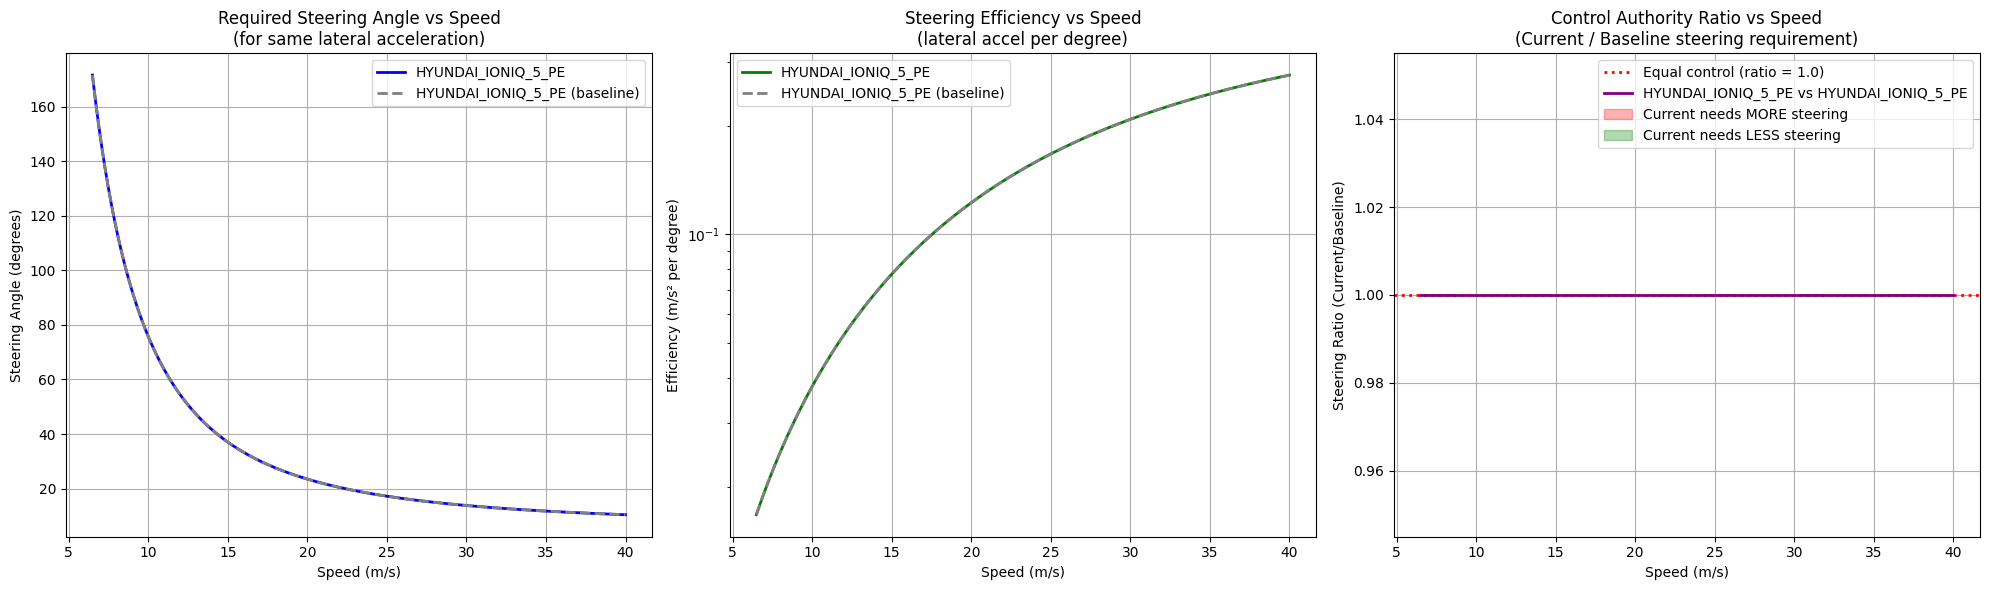


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
HYUNDAI_IONIQ_5_PE vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 2.87088 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    75.7      75.7      0.0379      0.0379      1.00        Within 0.19999999999999996 of difference.
15.0    37.0      37.0      0.0776      0.0776      1.00        Within 0.19999999999999996 of difference.
20.0    23.5      23.5      0.1223      0.1223      1.00        Within 0.19999999999999996 of difference.
25.0    17.2      17.2      0.1669      0.1669      1.00        Within 0.19999999999999996 of difference.
30.0    13.8      13.8      0.2081      0.2081      1.00        Within 0.19999999999999996 of difference.
35.0    11.7      11.7      0.2445      0.2445      1.00   

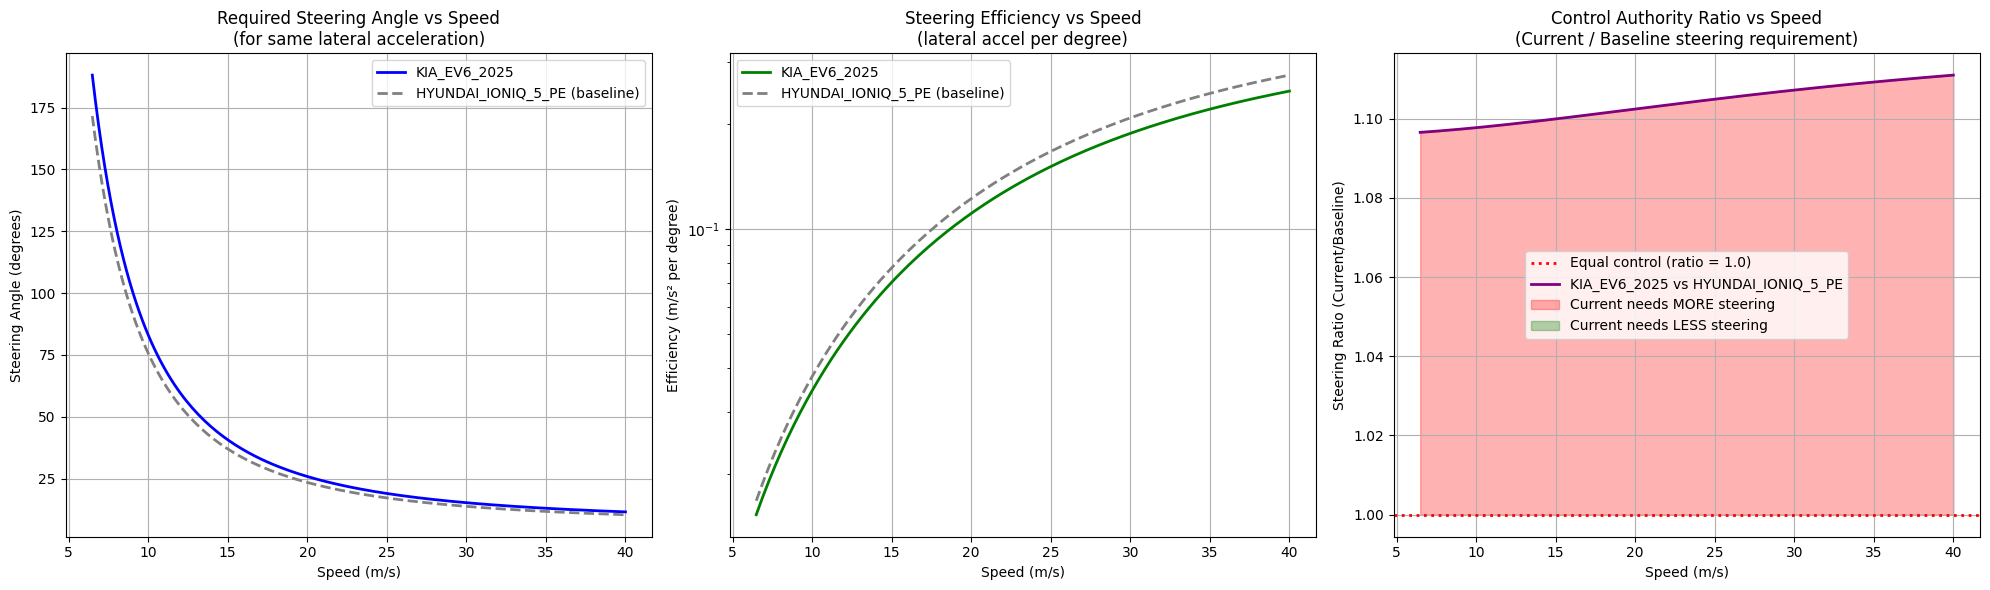


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
KIA_EV6_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 2.87088 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    83.1      75.7      0.0345      0.0379      1.10        Within 0.19999999999999996 of difference.
15.0    40.7      37.0      0.0705      0.0776      1.10        Within 0.19999999999999996 of difference.
20.0    25.9      23.5      0.1110      0.1223      1.10        Within 0.19999999999999996 of difference.
25.0    19.0      17.2      0.1511      0.1669      1.10        Within 0.19999999999999996 of difference.
30.0    15.3      13.8      0.1880      0.2081      1.11        Within 0.19999999999999996 of difference.
35.0    13.0      11.7      0.2205      0.2445      1.11        W

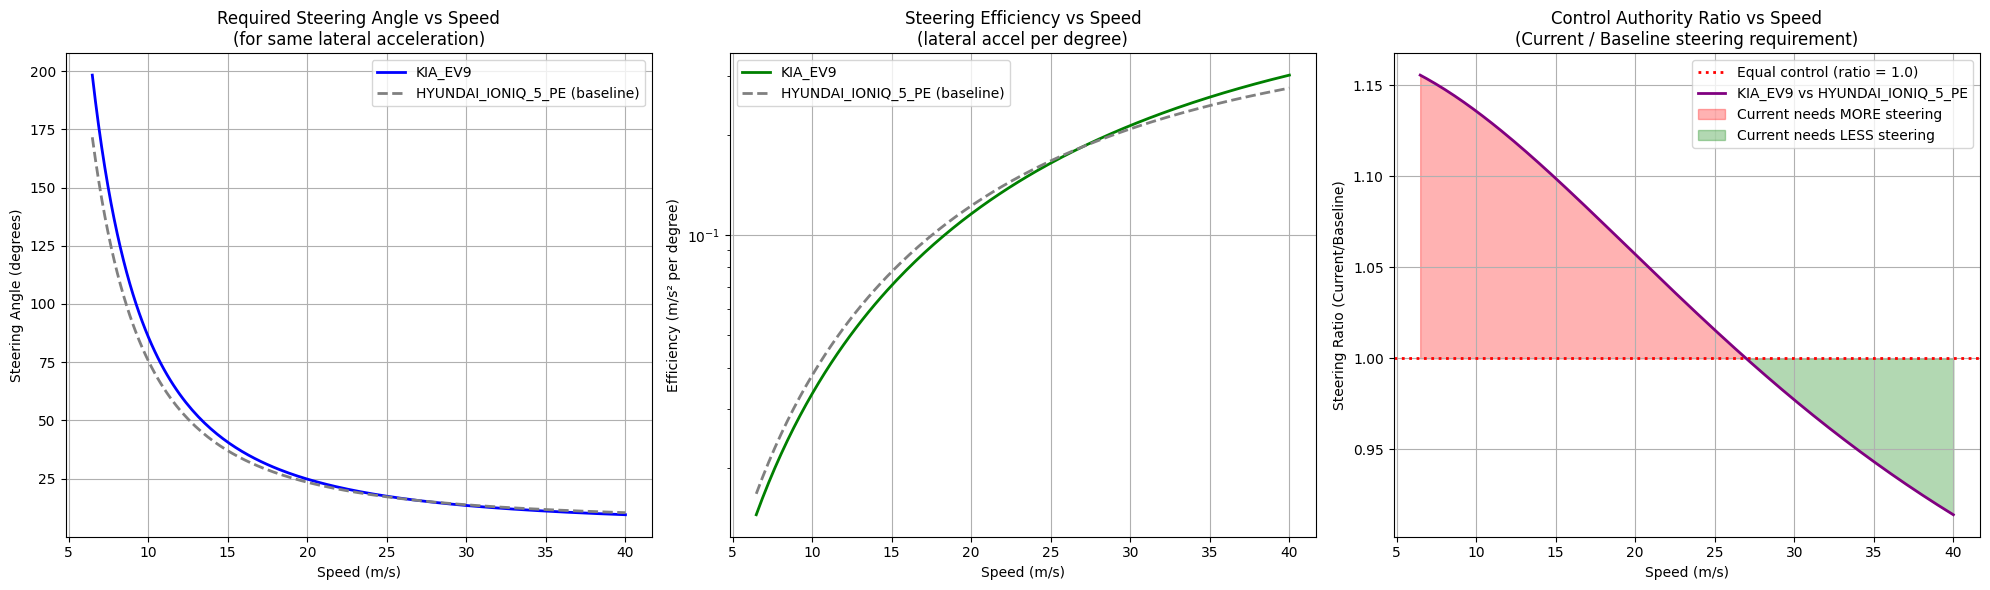


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
KIA_EV9 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 2.87088 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    86.0      75.7      0.0334      0.0379      1.14        Within 0.19999999999999996 of difference.
15.0    40.7      37.0      0.0706      0.0776      1.10        Within 0.19999999999999996 of difference.
20.0    24.8      23.5      0.1157      0.1223      1.06        Within 0.19999999999999996 of difference.
25.0    17.5      17.2      0.1643      0.1669      1.02        Within 0.19999999999999996 of difference.
30.0    13.5      13.8      0.2130      0.2081      0.98        Within 0.19999999999999996 of difference.
35.0    11.1      11.7      0.2592      0.2445      0.94        Within

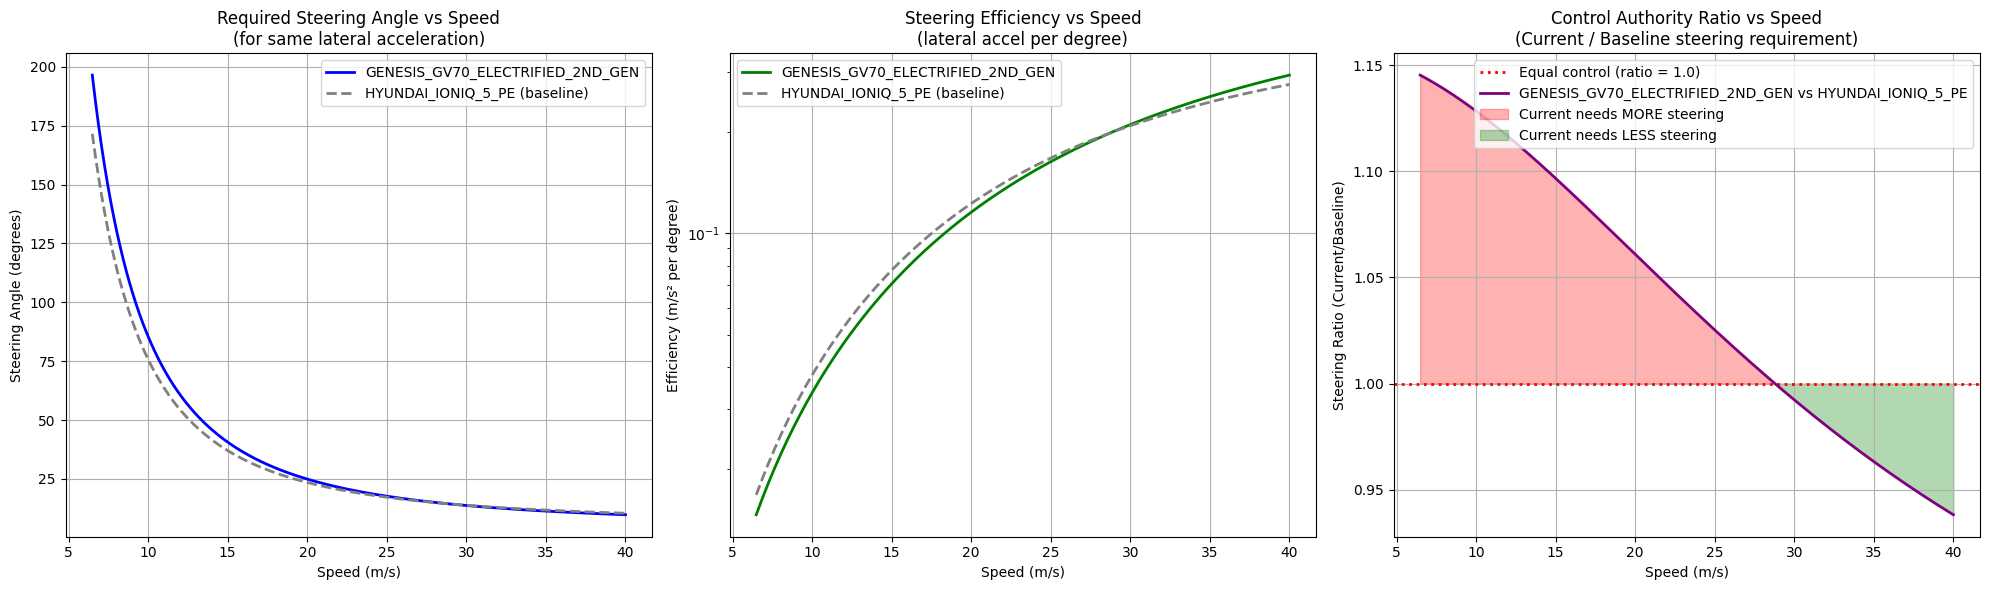


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
GENESIS_GV70_ELECTRIFIED_2ND_GEN vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 2.87088 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    85.4      75.7      0.0336      0.0379      1.13        Within 0.19999999999999996 of difference.
15.0    40.6      37.0      0.0707      0.0776      1.10        Within 0.19999999999999996 of difference.
20.0    24.9      23.5      0.1153      0.1223      1.06        Within 0.19999999999999996 of difference.
25.0    17.6      17.2      0.1628      0.1669      1.03        Within 0.19999999999999996 of difference.
30.0    13.7      13.8      0.2097      0.2081      0.99        Within 0.19999999999999996 of difference.
35.0    11.3      11.7      0.2539      0.244

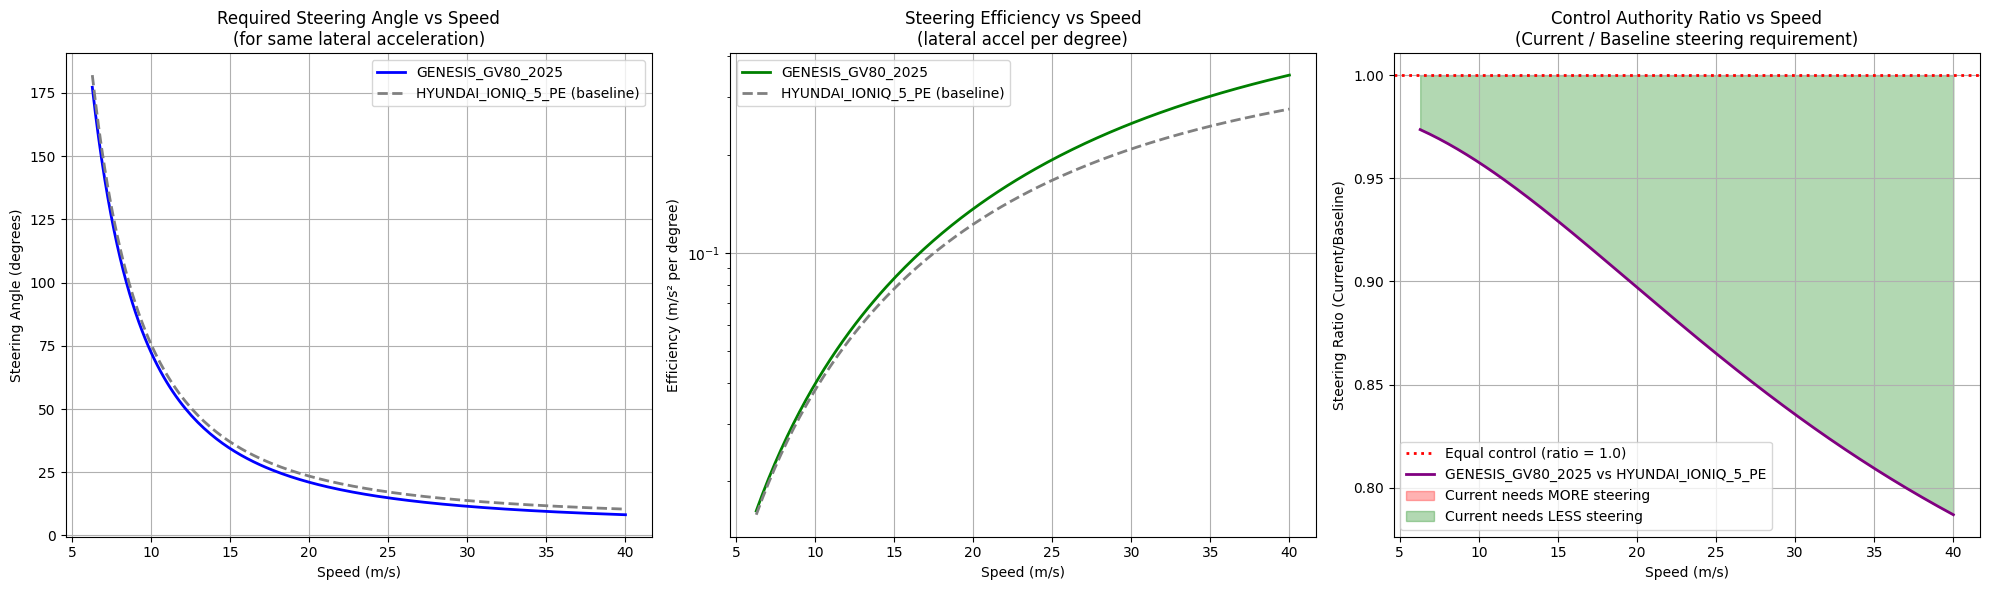


[STEERING EFFICIENCY & CONTROL AUTHORITY ANALYSIS]
GENESIS_GV80_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral acceleration: 2.87088 m/s²

Speed   Current   Baseline  Efficiency  Base Eff    Authority   Interpretation      
(m/s)   Angle(°)  Angle(°)  (m/s²/°)    (m/s²/°)    Ratio                           
--------------------------------------------------------------------------------------------------------
10.0    72.5      75.7      0.0396      0.0379      0.96        Within 0.19999999999999996 of difference.
15.0    34.4      37.0      0.0835      0.0776      0.93        Within 0.19999999999999996 of difference.
20.0    21.1      23.5      0.1364      0.1223      0.90        Within 0.19999999999999996 of difference.
25.0    14.9      17.2      0.1929      0.1669      0.87        Within 0.19999999999999996 of difference.
30.0    11.5      13.8      0.2491      0.2081      0.84        Within 0.19999999999999996 of difference.
35.0    9.5       11.7      0.3021      0.2445      0.81    

In [6]:
for car_name in PLATFORMS:
    analysis = compare_max_angle_plot(car_name, BASELINE_CAR, True)
    safety_summary(car_name, BASELINE_CAR, analysis)
    print("-"*120)
print(f"Comparison complete across {len(PLATFORMS)} Hyundai models with CANFD angle steering support.")

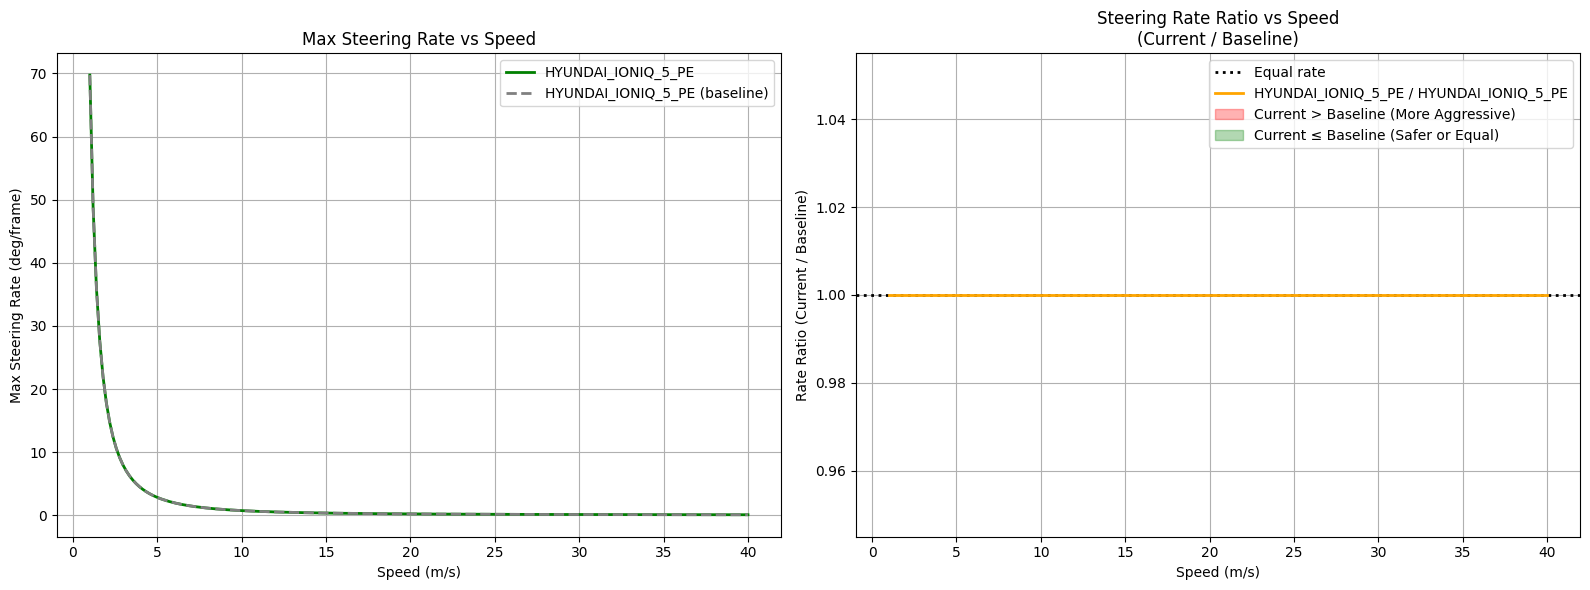


[STEERING RATE SAFETY CHECK] HYUNDAI_IONIQ_5_PE vs HYUNDAI_IONIQ_5_PE
Target lateral jerk limit: 2.87 m/s³

Speed   Current     Baseline    Rate Ratio  Safety Assessment        
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                                
---------------------------------------------------------------------------
5.0     2.8471      2.8471      1.00        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
10.0    0.7572      0.7572      1.00        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
15.0    0.3701      0.3701      1.00        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
20.0    0.2347      0.2347      1.00        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
25.0    0.1720      0.1720      1.00        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
30.0    0.1379      0.1379      1.00        ✅ Compatible with baseline sincw within threshold 0.199999999

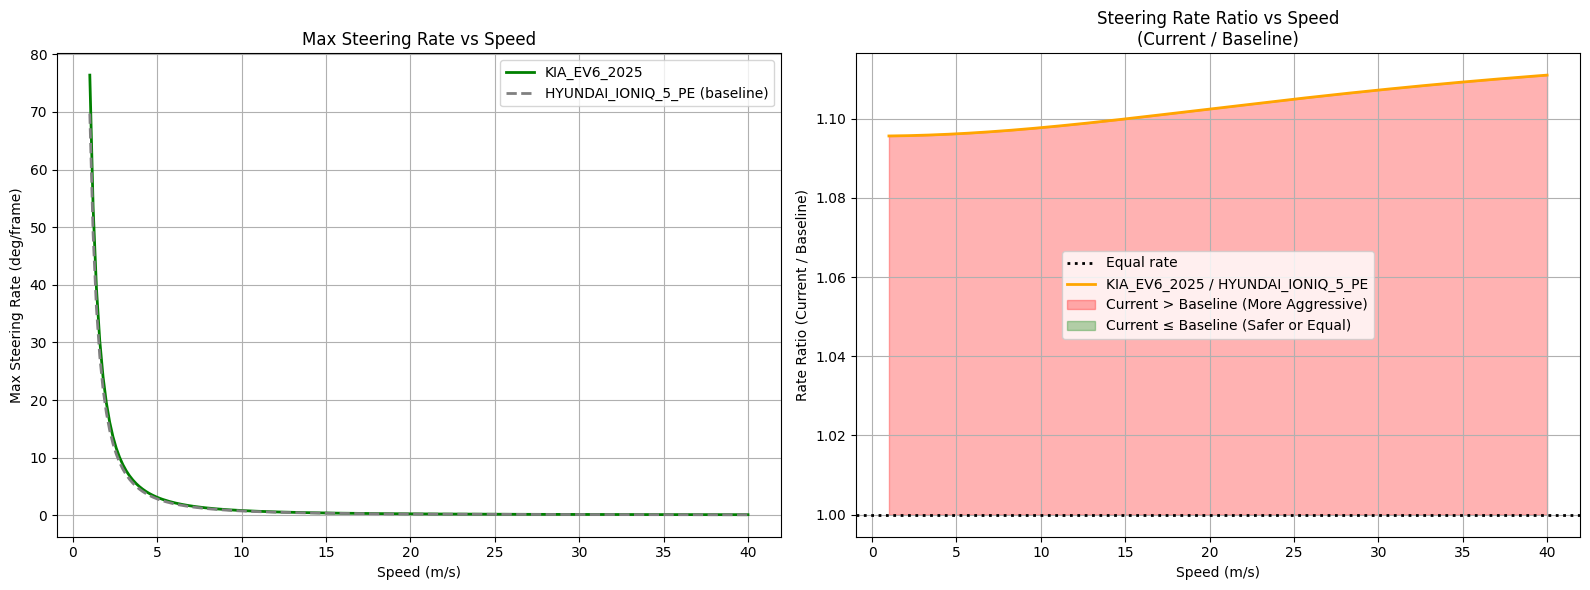


[STEERING RATE SAFETY CHECK] KIA_EV6_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk limit: 2.87 m/s³

Speed   Current     Baseline    Rate Ratio  Safety Assessment        
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                                
---------------------------------------------------------------------------
5.0     3.1208      2.8471      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
10.0    0.8311      0.7572      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
15.0    0.4071      0.3701      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
20.0    0.2587      0.2347      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
25.0    0.1900      0.1720      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
30.0    0.1527      0.1379      1.11        ✅ Compatible with baseline sincw within threshold 0.199999999999999

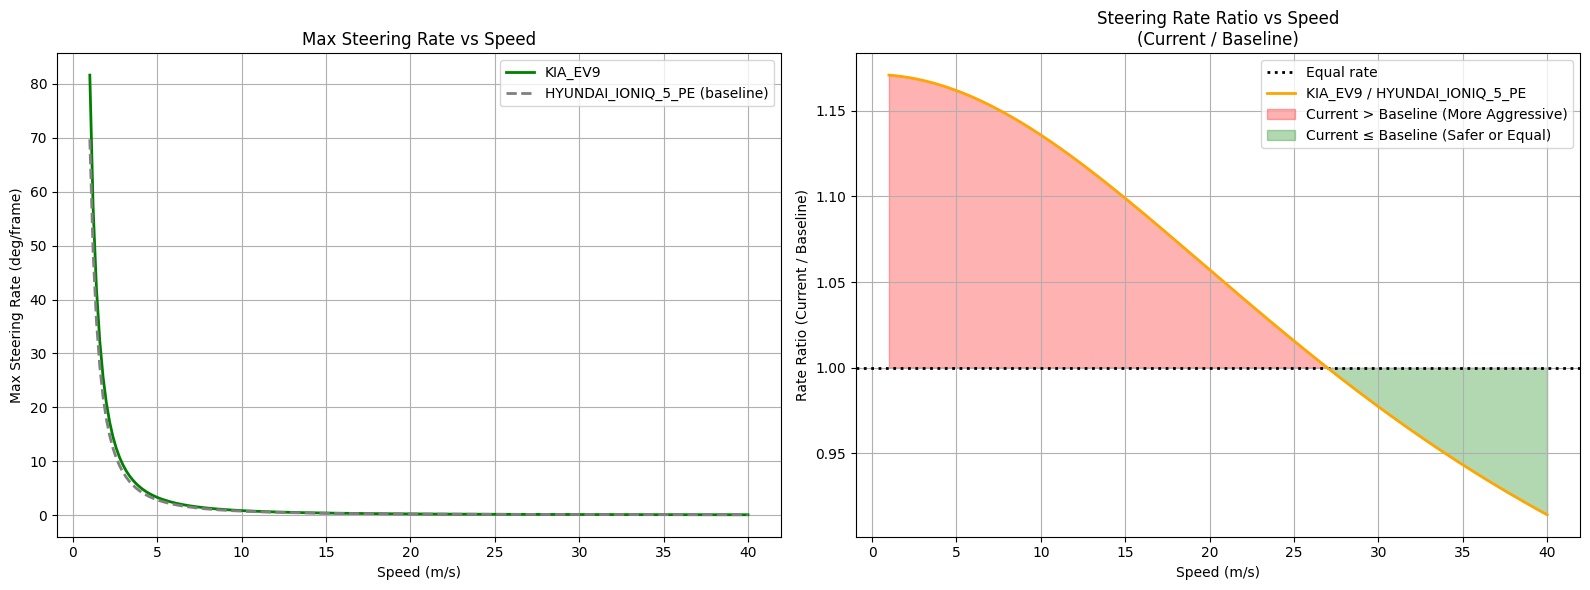


[STEERING RATE SAFETY CHECK] KIA_EV9 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk limit: 2.87 m/s³

Speed   Current     Baseline    Rate Ratio  Safety Assessment        
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                                
---------------------------------------------------------------------------
5.0     3.3076      2.8471      1.16        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
10.0    0.8600      0.7572      1.14        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
15.0    0.4068      0.3701      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
20.0    0.2481      0.2347      1.06        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
25.0    0.1747      0.1720      1.02        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
30.0    0.1348      0.1379      0.98        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
35

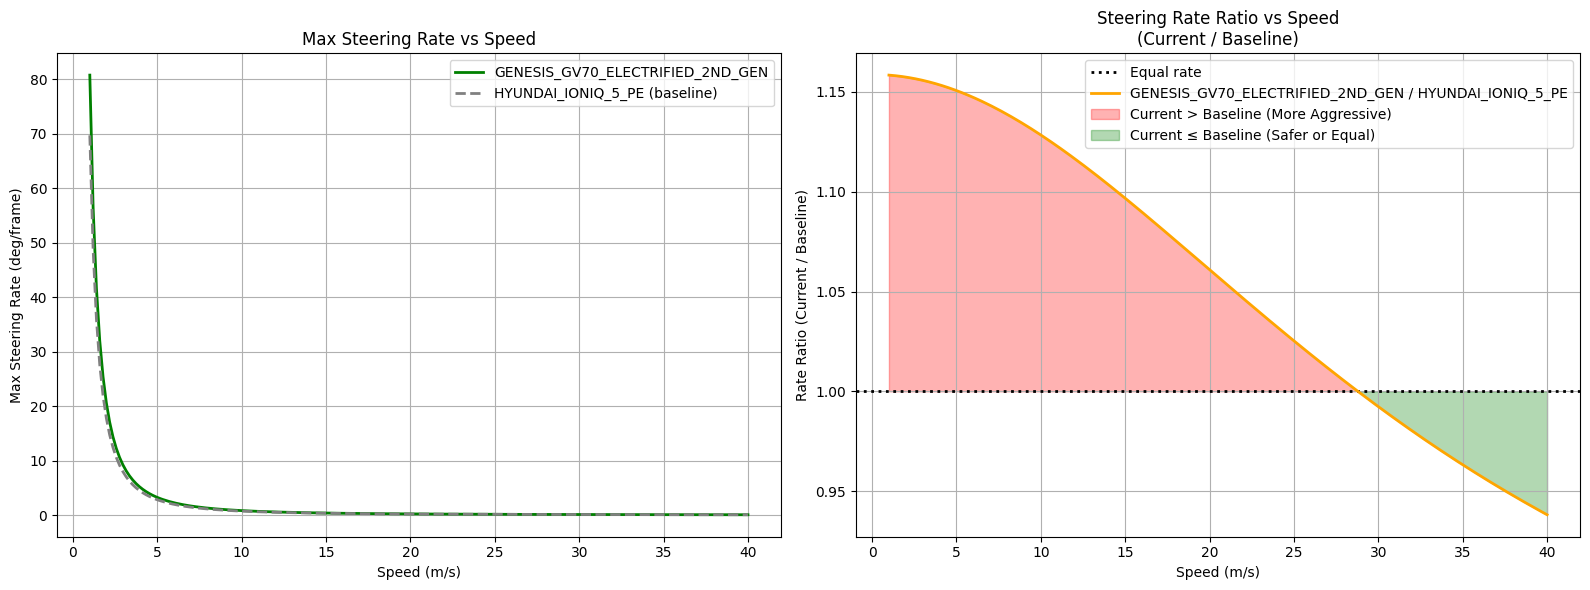


[STEERING RATE SAFETY CHECK] GENESIS_GV70_ELECTRIFIED_2ND_GEN vs HYUNDAI_IONIQ_5_PE
Target lateral jerk limit: 2.87 m/s³

Speed   Current     Baseline    Rate Ratio  Safety Assessment        
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                                
---------------------------------------------------------------------------
5.0     3.2762      2.8471      1.15        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
10.0    0.8544      0.7572      1.13        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
15.0    0.4060      0.3701      1.10        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
20.0    0.2490      0.2347      1.06        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
25.0    0.1763      0.1720      1.03        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
30.0    0.1369      0.1379      0.99        ✅ Compatible with baseline sincw within thresho

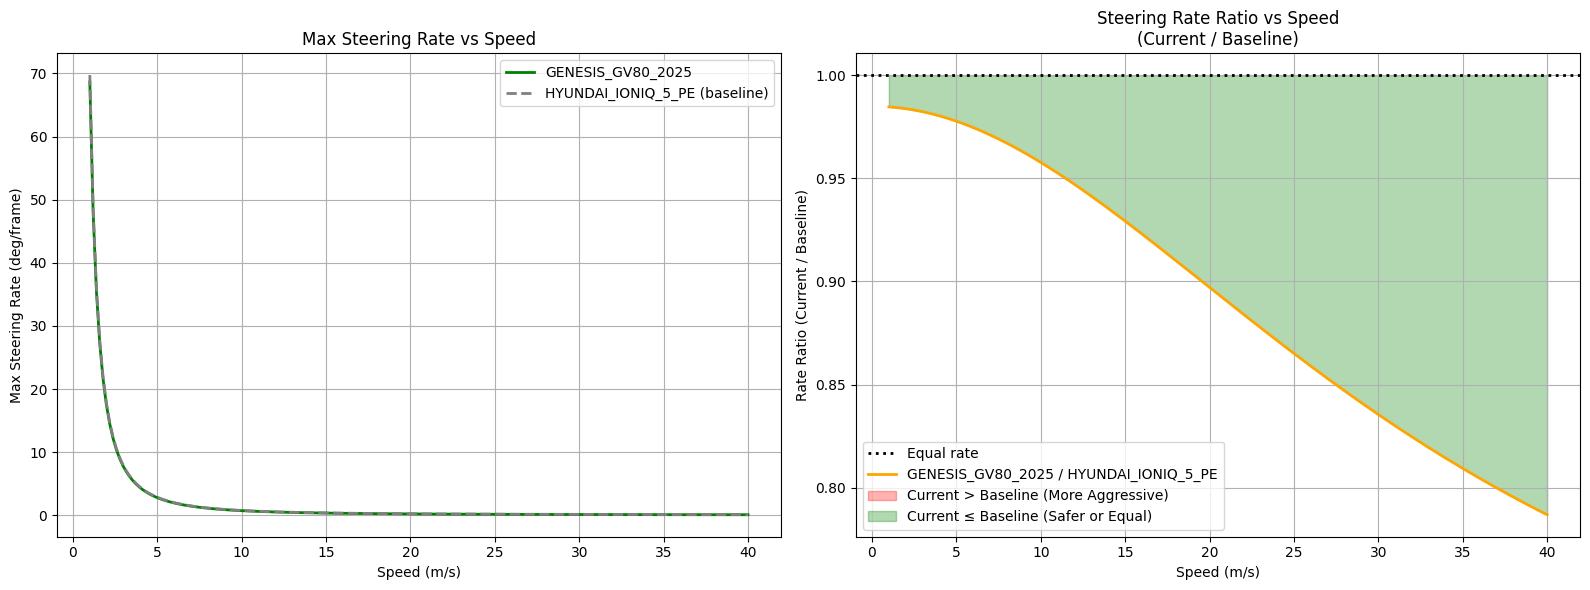


[STEERING RATE SAFETY CHECK] GENESIS_GV80_2025 vs HYUNDAI_IONIQ_5_PE
Target lateral jerk limit: 2.87 m/s³

Speed   Current     Baseline    Rate Ratio  Safety Assessment        
(m/s)   Rate(°/f)   Rate(°/f)   (C/B)                                
---------------------------------------------------------------------------
5.0     2.7835      2.8471      0.98        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
10.0    0.7251      0.7572      0.96        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
15.0    0.3440      0.3701      0.93        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
20.0    0.2105      0.2347      0.90        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
25.0    0.1488      0.1720      0.87        ✅ Compatible with baseline sincw within threshold 0.19999999999999996
30.0    0.1152      0.1379      0.84        ✅ Compatible with baseline sincw within threshold 0.1999999999

In [7]:
for car_name in PLATFORMS:
    compare_max_angle_delta_plot(car_name, BASELINE_CAR)
print(f"Comparison complete across {len(PLATFORMS)} Hyundai models with CANFD angle steering support.")